In [ ]:
#ConvNeXt-Small
!pip install -q timm torch torchvision scikit-learn seaborn

import os, shutil, torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# CHANGE this to your dataset path in Drive
base_dir = '/content/drive/MyDrive/oral_cancer_dataset'

# Merge into two classes: Healthy & Oral_Cancer
merged_dir = '/content/oral_cancer_2class'
os.makedirs(os.path.join(merged_dir, 'Healthy'), exist_ok=True)
os.makedirs(os.path.join(merged_dir, 'Oral_Cancer'), exist_ok=True)

for src_cls, dest_cls in [
    ('OCA', 'Oral_Cancer'),
    ('OPMD', 'Oral_Cancer'),
    ('Benign', 'Healthy'),
    ('Healthy', 'Healthy')
]:
    src_path = os.path.join(base_dir, src_cls)
    if os.path.exists(src_path):
        for f in os.listdir(src_path):
            src_file = os.path.join(src_path, f)
            dst_file = os.path.join(merged_dir, dest_cls, f'{src_cls}_{f}')
            if os.path.isfile(src_file):
                shutil.copy(src_file, dst_file)

# Check final dataset
for cls in os.listdir(merged_dir):
    print(f"{cls:15s} → {len(os.listdir(os.path.join(merged_dir, cls)))} images")


Mounted at /content/drive
Oral_Cancer     → 1523 images
Healthy         → 1478 images


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

dataset = datasets.ImageFolder(merged_dir, transform=transform)
classes = dataset.classes
print("Classes:", classes)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)


Classes: ['Healthy', 'Oral_Cancer']


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

model = timm.create_model('convnext_small', pretrained=True, num_classes=2)
model = model.to(device)

# Compute class weights
train_labels = [dataset.targets[i] for i in train_ds.indices]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

In [ ]:
epochs = 6
for epoch in range(epochs):
    model.train()
    total, correct, loss_sum = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss_sum/len(train_loader):.4f} | Train Acc: {acc:.2f}%")


Epoch 1/6 | Loss: 0.7398 | Train Acc: 48.29%
Epoch 2/6 | Loss: 0.7187 | Train Acc: 50.04%
Epoch 3/6 | Loss: 0.7028 | Train Acc: 50.58%
Epoch 4/6 | Loss: 0.6959 | Train Acc: 51.04%
Epoch 5/6 | Loss: 0.6933 | Train Acc: 53.75%
Epoch 6/6 | Loss: 0.6914 | Train Acc: 53.88%


In [ ]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print("\n✅ ConvNeXt-Small Performance:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print("\nDetailed Classification Report:\n", classification_report(y_true, y_pred, target_names=dataset.classes))



✅ ConvNeXt-Small Performance:
Accuracy : 0.5674
Precision: 0.6105
Recall   : 0.3841
F1-Score : 0.4715

Detailed Classification Report:
               precision    recall  f1-score   support

     Healthy       0.55      0.75      0.63       299
 Oral_Cancer       0.61      0.38      0.47       302

    accuracy                           0.57       601
   macro avg       0.58      0.57      0.55       601
weighted avg       0.58      0.57      0.55       601



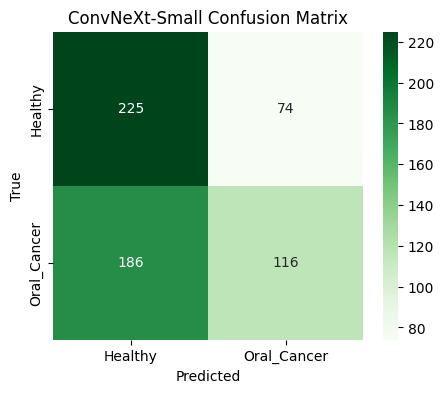

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ConvNeXt-Small Confusion Matrix')
plt.show()


In [ ]:
torch.save(model.state_dict(), '/content/convnext_small_oral_cancer_model.pth')
print("✅ Model saved successfully!")


✅ Model saved successfully!
